In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df= pd.read_feather("dataset/dailyGrouping.feather")
df_traffic=pd.read_csv("info/trafficLevels.csv")

df_traffic = pd.read_csv("info/trafficLevels.csv", index_col=0)
df_traffic_long = df_traffic.T.reset_index().melt(id_vars='index', var_name='city', value_name='trafficLevel')
df_traffic_long = df_traffic_long.rename(columns={'index': 'station'})#Adaptation of traffic data for merging with general dataset.

df_traffic_long['city'] = df_traffic_long['city'].astype(int)
df_traffic_long['station'] = df_traffic_long['station'].astype(int)

df_cities=pd.read_csv("info/cityInfo.csv")
df['weather']=(df["weather"]*2).round()/2
df = df.merge(df_cities[['city', 'popDensity','population','size']], on='city', how='left')
df=df.merge(df_traffic_long[['city','station','trafficLevel']],on=['city','station'],how='left')
df['log_popDensity']=np.log(df['popDensity'])

In [2]:
df_polApp=df[(df['treated']==1)]
df_polNA=df[df['treated']==0] #Separating the stations where the policy has been applied 
print("The stations where the policy was applied are:")
print(df_polApp[['city','station']].drop_duplicates().to_string(index=False)) #Stations where the policy was applied

The stations where the policy was applied are:
 city  station
    1        1
    1        2
    1        3
    1        5
    1        6
    1        8
    1        9
    1       10


In [3]:
df_1_1=df_polApp[(df_polApp['city']==1)&(df_polApp['station']==10)]
df_1_2=df_polNA[(df_polNA['city']==1)&(df_polNA['station']==4)]

C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\2667793823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_1['date_str'] = df_1_1['date'].dt.strftime('%m-%d')
C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\2667793823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_2['date_str'] = df_1_2['date'].dt.strftime('%m-%d')


The maximum speed without new policy is: 40.0
The maximum speed with new policy is: 25.0


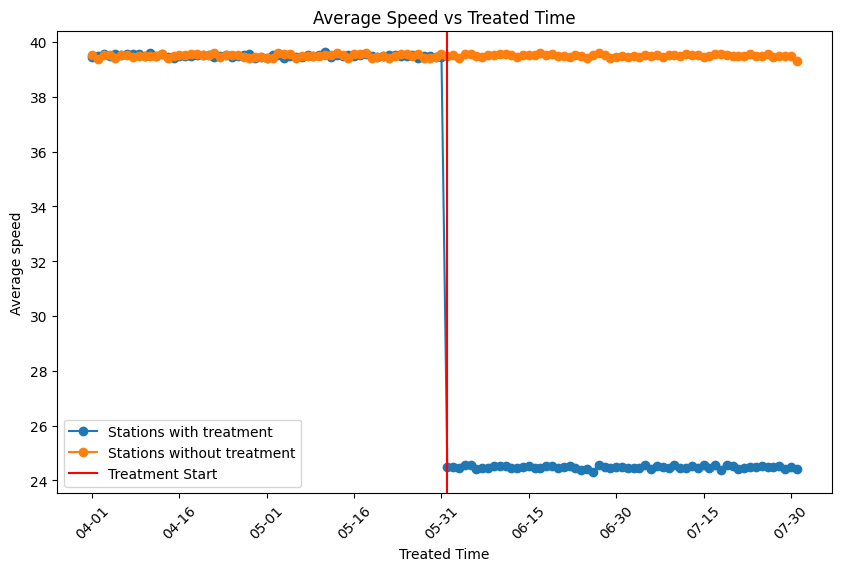

In [4]:
from matplotlib.ticker import MaxNLocator

df_1_1['date_str'] = df_1_1['date'].dt.strftime('%m-%d')
df_1_2['date_str'] = df_1_2['date'].dt.strftime('%m-%d')
treatment_start=df_1_1[df_1_1['treated_time']==0]['date'].iloc[0]
treatment_start_str=treatment_start.strftime('%m-%d')
plt.figure(figsize=(10,6))
plt.plot(df_1_1['date_str'],df_1_1['speed'],marker='o',label='Stations with treatment')
plt.plot(df_1_2['date_str'],df_1_2['speed'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average speed')
plt.title('Average Speed vs Treated Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.axvline(treatment_start_str,color='red',label='Treatment Start')
plt.legend()
print("The maximum speed without new policy is:",df_polNA['speed'].max().round())
print("The maximum speed with new policy is:",df_polApp[df_polApp['treated_time']>0]['speed'].max().round())

The maximum speed without new policy is: 9.1
The maximum speed with new policy is: 11.2


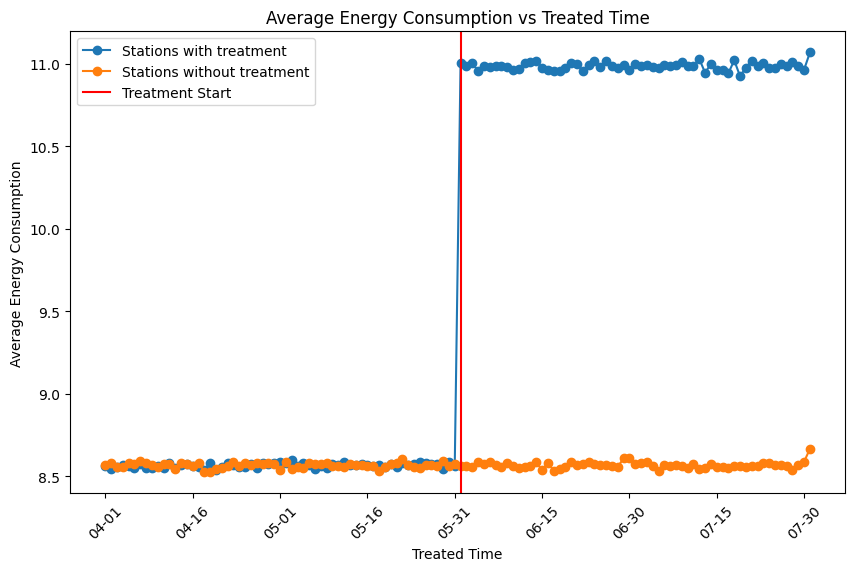

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df_1_1['date_str'],df_1_1['energyConsumption'],marker='o',label='Stations with treatment')
plt.plot(df_1_2['date_str'],df_1_2['energyConsumption'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average Energy Consumption')
plt.title('Average Energy Consumption vs Treated Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.axvline(treatment_start_str,color='red',label='Treatment Start')
plt.legend()


print("The maximum speed without new policy is:",df_polNA['energyConsumption'].max().round(1))
print("The maximum speed with new policy is:",df_polApp[df_polApp['treated_time']>0]['energyConsumption'].max().round(1))

In [6]:
group_variance = df_polApp.groupby(['city', 'station'])['trafficCongestion'].transform('var')
df_polApp['trafficVariance'] = group_variance
group_variance = df_polNA.groupby(['city', 'station'])['trafficCongestion'].transform('var')
df_polNA['trafficVariance'] = group_variance

df_polNA_1=df_polNA[df_polNA['trafficVariance']>0]
df_polApp_1=df_polApp[df_polApp['trafficVariance']>0]#Getting rid of stations with constant data in traffic congestion.

C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\1184366135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polApp['trafficVariance'] = group_variance
C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\1184366135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polNA['trafficVariance'] = group_variance


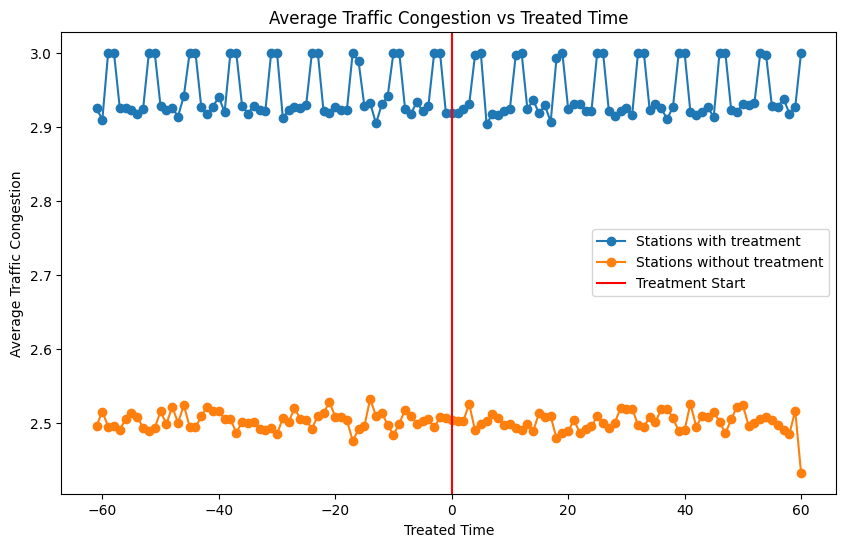

In [7]:
df_polApp_avg=df_polApp.groupby('treated_time').mean().reset_index()#For car crashes and pedestrian death analysis
df_polNA_avg=df_polNA.groupby('treated_time').mean().reset_index()
df_polApp_avg_1=df_polApp_1.groupby('treated_time').mean().reset_index()#For traffic analysis
df_polNA_avg_1=df_polNA_1.groupby('treated_time').mean().reset_index()
plt.figure(figsize=(10,6))
plt.plot(df_polApp_avg_1['treated_time'],df_polApp_avg_1['trafficCongestion'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg_1['treated_time'],df_polNA_avg_1['trafficCongestion'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average Traffic Congestion')
plt.title('Average Traffic Congestion vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()


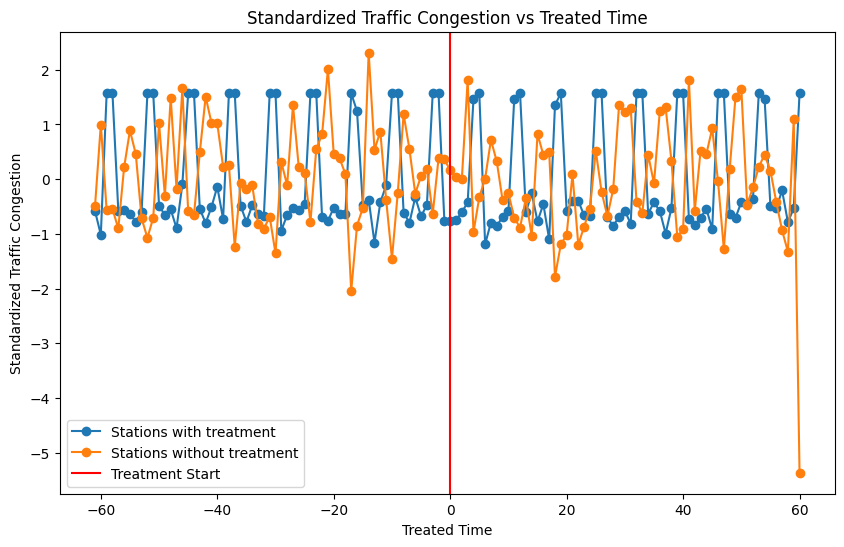

In [8]:
df_polApp_avg_1["traffic_standardized"] = (df_polApp_avg_1["trafficCongestion"] - df_polApp_avg_1["trafficCongestion"].mean()) / df_polApp_avg_1["trafficCongestion"].std()
df_polNA_avg_1["traffic_standardized"] = (df_polNA_avg_1["trafficCongestion"] - df_polNA_avg_1["trafficCongestion"].mean()) / df_polNA_avg_1["trafficCongestion"].std()
plt.figure(figsize=(10, 6))
plt.plot(df_polApp_avg_1['treated_time'],df_polApp_avg_1['traffic_standardized'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg_1['treated_time'],df_polNA_avg_1['traffic_standardized'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Standardized Traffic Congestion')
plt.title('Standardized Traffic Congestion vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [9]:
import statsmodels.formula.api as smf

df_polApp_1["group"] = 1  # treated
df_polNA_1["group"] = 0  # control   For traffic analysis

df_polApp["group"] = 1  # treated
df_polNA["group"] = 0  # control     For car crashes and pedestrian death analysis

df_all = pd.concat([df_polApp_1, df_polNA_1], ignore_index=True)

df_all["post"] = df_all["treated_time"] >= 0

# Difference-in-Differences regression
model = smf.ols("trafficCongestion ~ group + post + group:post + log_popDensity + size +C(trafficLevel)+C(dow)+C(weather)", data=df_all).fit(cov_type='HC3')
print(len(df_all))
model.summary()

5490


C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\1965132223.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polNA_1["group"] = 0  # control   For traffic analysis
C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\1965132223.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polApp["group"] = 1  # treated
C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\1965132223.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      trafficCongestion   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     946.3
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        14:54:48   Log-Likelihood:                -2139.8
No. Observations:                5490   AIC:                             4316.
Df Residuals:                    5472   BIC:                             4435.
Df Model:                          17                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.7093      0.210     36.656      0.000       7.297       8.122
post[T.True]            -0.0019      0.012     -0.165      0.869      -0.025       0.021
C(trafficLevel)[T.2]    -0.2516      0.012    -20.135      0.000      -0.276      -0.227
C(trafficLevel)[T.3]    -0.2348      0.014    -16.334      0.000      -0.263      -0.207
C(dow)[T.2.0]            0.0023      0.017      0.135      0.893      -0.031       0.036
C(dow)[T.3.0]            0.0042      0.017      0.246      0.805      -0.029       0.037
C(dow)[T.4.0]           -0.0008      0.017     -0.045      0.964      -0.034       0.032
C(dow)[T.5.0]            0.0021      0.017      0.127      0.899      -0.031       0.035
C(dow)[T.6.0]            0.0021      0.019      0.110      0.912      -0.035       0.040
C(dow)[T.7.0]            0.0057      0.019      0.298      0.766      -0.032       0.043
C(weather)[T.1.5]        0.0668      0.135      0.493      0.622      -0.199       0.332
C(weather)[T.2.0]        0.0555      0.134      0.415      0.678      -0.207       0.318
C(weather)[T.2.5]        0.0668      0.135      0.496      0.620      -0.197       0.331
C(weather)[T.3.0]        0.1409      0.171      0.822      0.411      -0.195       0.477
group                    0.2005      0.009     22.968      0.000       0.183       0.218
group:post[T.True]      -0.0005      0.014     -0.035      0.972      -0.028       0.027
log_popDensity          -0.4488      0.018    -24.302      0.000      -0.485      -0.413
size                    -0.0075      0.000    -48.146      0.000      -0.008      -0.007
==============================================================================
Omnibus:                      752.784   Durbin-Watson:                   0.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1297.131
Skew:                           0.910   Prob(JB):                    2.15e-282
Kurtosis:                       4.536   Cond. No.                     1.53e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R^2 of 0.701 implies that the model is pretty accurate, but the group:post DiD coefficient is very close to 0, and more important, the p-value (0.972) is too big, so the treatment didn't actually have an impact in traffic congestion

C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\1295198126.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_1['group_label']=df_all_1['group'].map({0:"Control",1:"Treated"})
C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\1295198126.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_1["period"] = df_all_1["post"].map({0: "Before", 1: "After"})


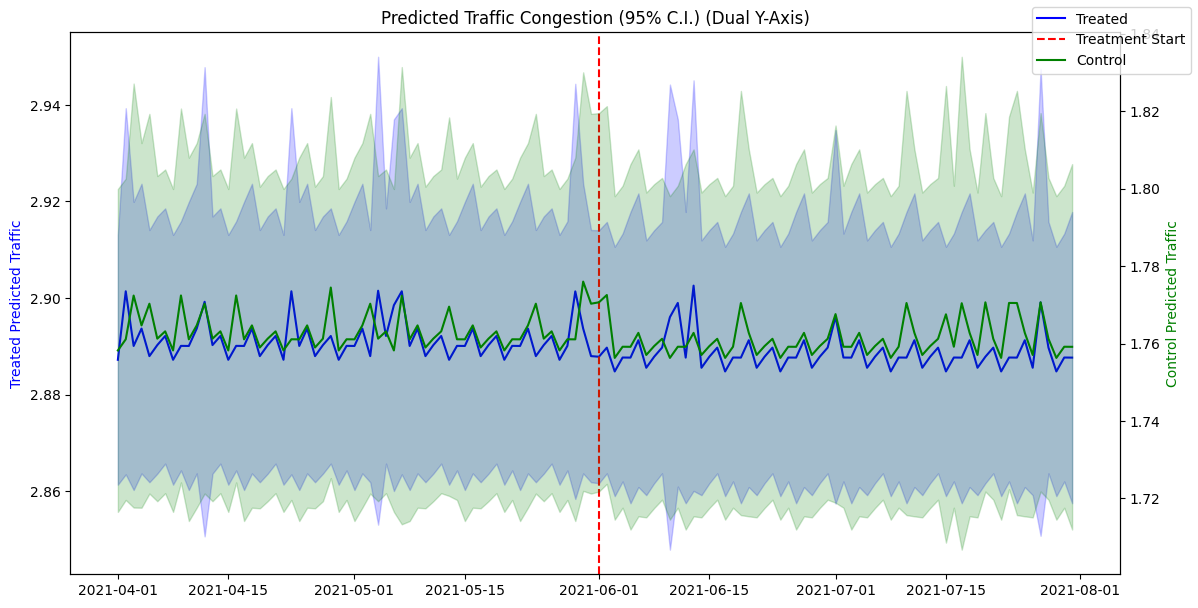

In [10]:
import seaborn as sns

predictions=model.get_prediction(df_all)

df_all['predictedTraffic']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8)) | ((df_all['city']==4) & (df_all['station']==1))]

df_all_1['group_label']=df_all_1['group'].map({0:"Control",1:"Treated"})
df_all_1["period"] = df_all_1["post"].map({0: "Before", 1: "After"})
df_all_1 = df_all_1.dropna(subset=['predictedTraffic', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all_1[df_all_1['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedTraffic'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Traffic', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all_1[df_all_1['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedTraffic'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Traffic', color='green')

# Treatment start line
treatment_start = df_all_1[df_all_1['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Traffic Congestion (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

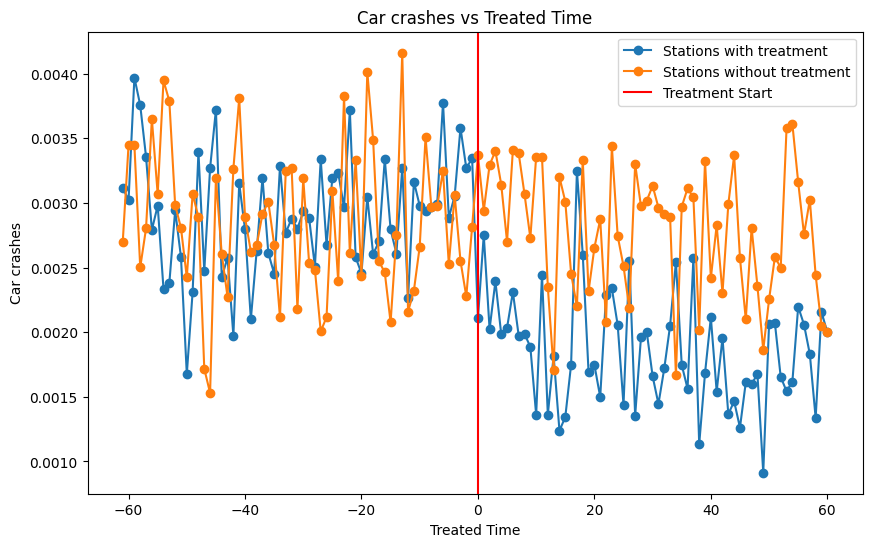

In [11]:
df_all = pd.concat([df_polApp, df_polNA], ignore_index=True)

df_all["post"] = df_all["treated_time"] >= 0

df_all_1=df_all[((df_all['city']==1) & (df_all['station']==10))]
df_all_2=df_all[((df_all['city']==6) & (df_all['station']==4))]

plt.figure(figsize=(10, 6))
plt.plot(df_all_1['treated_time'],df_all_1['carCrash'],marker='o',label='Stations with treatment')
plt.plot(df_all_2['treated_time'],df_all_2['carCrash'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Car crashes')
plt.title('Car crashes vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [12]:
model = smf.ols("carCrash ~ group + post + group:post + size + log_popDensity + C(trafficLevel)  + C(weather) +C(dow)", data=df_all).fit(cov_type='HC3')

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               carCrash   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     362.1
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        14:54:49   Log-Likelihood:                 40745.
No. Observations:                7320   AIC:                        -8.145e+04
Df Residuals:                    7302   BIC:                        -8.133e+04
Df Model:                          17                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0002      0.001      0.415      0.678      -0.001       0.001
post[T.True]          2.734e-05   2.39e-05      1.144      0.253   -1.95e-05    7.42e-05
C(trafficLevel)[T.2]    -0.0002   3.05e-05     -5.174      0.000      -0.000   -9.79e-05
C(trafficLevel)[T.3]    -0.0002   2.69e-05     -7.500      0.000      -0.000      -0.000
C(weather)[T.1.5]       -0.0004      0.001     -0.806      0.420      -0.001       0.001
C(weather)[T.2.0]       -0.0004      0.001     -0.775      0.438      -0.001       0.001
C(weather)[T.2.5]       -0.0004      0.001     -0.788      0.431      -0.001       0.001
C(weather)[T.3.0]       -0.0005      0.001     -0.411      0.681      -0.003       0.002
C(dow)[T.2.0]        -3.544e-05   3.81e-05     -0.931      0.352      -0.000    3.92e-05
C(dow)[T.3.0]        -8.085e-06   3.87e-05     -0.209      0.834   -8.38e-05    6.77e-05
C(dow)[T.4.0]         -1.13e-05   3.73e-05     -0.303      0.762   -8.43e-05    6.17e-05
C(dow)[T.5.0]        -3.097e-05   3.76e-05     -0.823      0.411      -0.000    4.28e-05
C(dow)[T.6.0]         4.386e-05   4.34e-05      1.010      0.312   -4.12e-05       0.000
C(dow)[T.7.0]        -2.093e-05   3.78e-05     -0.553      0.580   -9.51e-05    5.32e-05
group                    0.0003   2.94e-05      9.658      0.000       0.000       0.000
group:post[T.True]      -0.0011   4.11e-05    -27.679      0.000      -0.001      -0.001
size                 -2.066e-06   2.55e-07     -8.093      0.000   -2.57e-06   -1.57e-06
log_popDensity           0.0004   2.93e-05     15.025      0.000       0.000       0.000
==============================================================================
Omnibus:                     4766.644   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           301600.866
Skew:                           2.409   Prob(JB):                         0.00
Kurtosis:                      34.075   Cond. No.                     1.37e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R^2 of 0.416 implies that the model is a little accurate, and the group:post DiD coefficient is very close to 0, but, the p-value (0.00) is lower than 0.01, so the treatment had a big impact in the frequency of car crashes.

In [13]:
df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8))]
df_all_2=df_all[((df_all['city']==4) & (df_all['station']==1))]

predictions=model.get_prediction(df_all)

df_all['predictedCrashes']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all['group_label']=df_all['group'].map({0:"Control",1:"Treated"})
df_all["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all = df_all.dropna(subset=['predictedCrashes', 'ci_lower', 'ci_upper'])


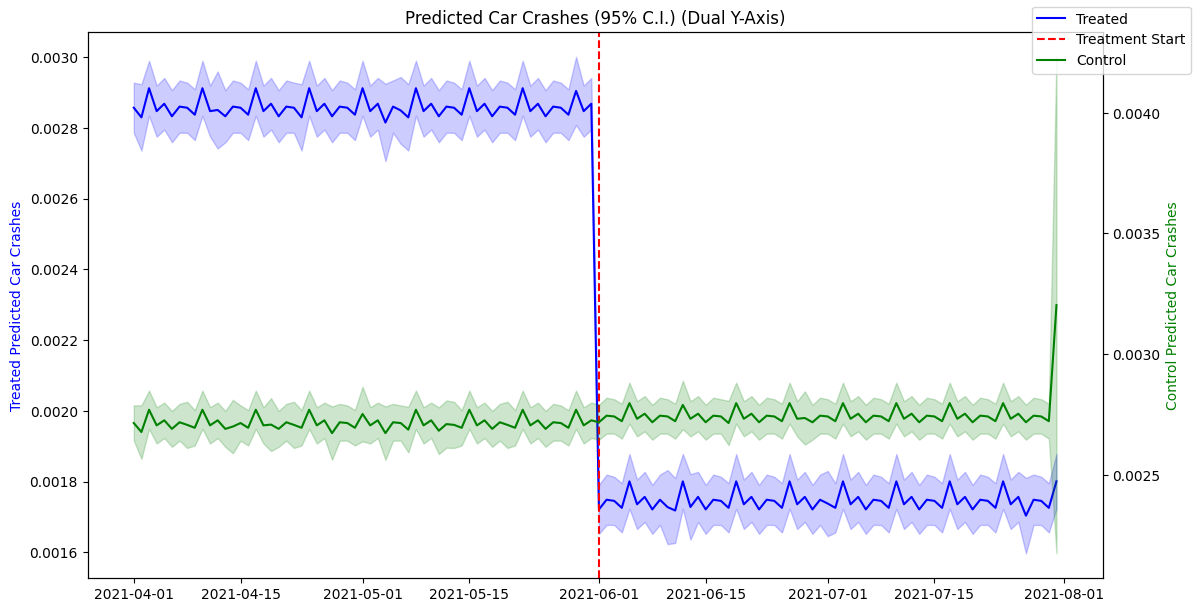

In [14]:
df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8)) | ((df_all['city']==6) & (df_all['station']==6))]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all_1[df_all_1['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedCrashes'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Car Crashes', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all_1[df_all_1['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedCrashes'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Car Crashes', color='green')

# Treatment start line
treatment_start = df_all_1[df_all_1['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Car Crashes (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

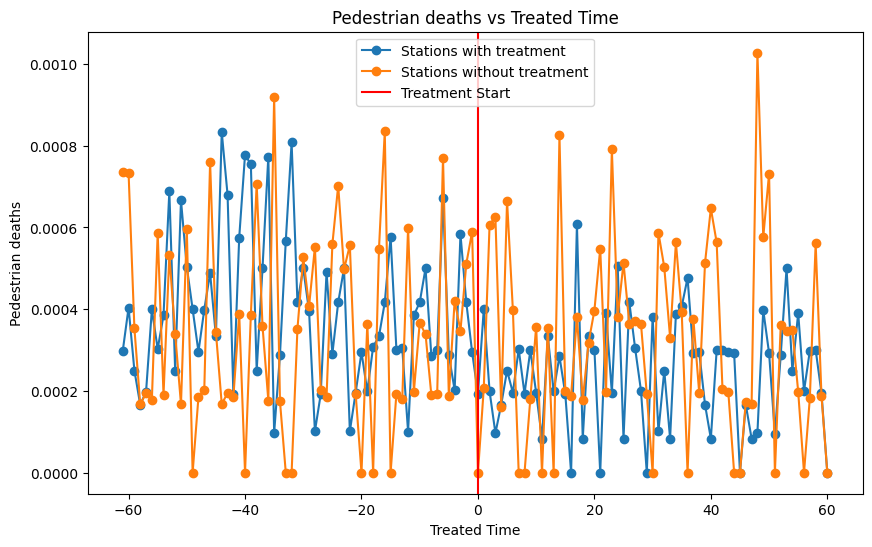

In [15]:
df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8))]
df_all_2=df_all[((df_all['city']==6) & (df_all['station']==1))]

plt.figure(figsize=(10, 6))
plt.plot(df_all_1['treated_time'],df_all_1['pedestrianDeath'],marker='o',label='Stations with treatment')
plt.plot(df_all_2['treated_time'],df_all_2['pedestrianDeath'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Pedestrian deaths')
plt.title('Pedestrian deaths vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [16]:
model = smf.ols("pedestrianDeath ~ group + post + group:post + C(dow)", data=df_all).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        pedestrianDeath   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.334
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.03e-10
Time:                        14:54:50   Log-Likelihood:                 48593.
No. Observations:                7320   AIC:                        -9.717e+04
Df Residuals:                    7310   BIC:                        -9.710e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0003   1.07

The R^2 of 0.009 implies that the model is not very accurate, and the group:post DiD coefficient is very close to 0, but, the p-value (0.00) is lower than 0.000, so the treatment had a clear impact in the frequency of pedestrian deaths.

C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\744780994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_1['predictedPedestrianDeath']=predictions.predicted_mean
C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\744780994.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_1['ci_lower'],df_all_1['ci_upper']=predictions.conf_int().T
C:\Users\fredo\AppData\Local\Temp\ipykernel_12676\744780994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

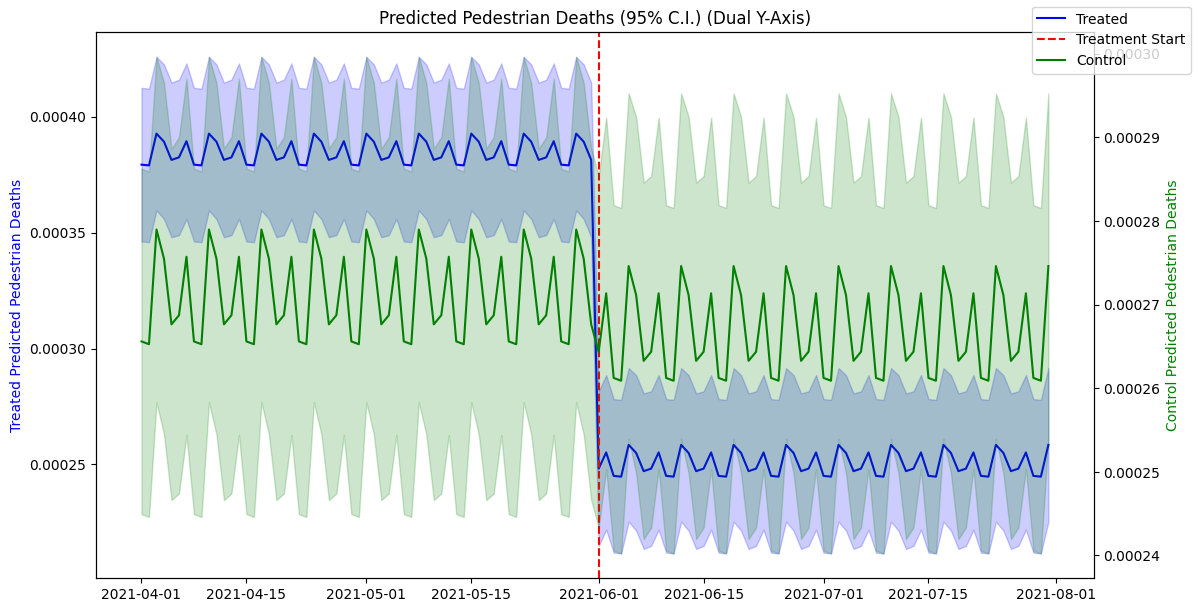

In [17]:
df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8)) | ((df_all['city']==6) & (df_all['station']==6))]

predictions=model.get_prediction(df_all_1)

df_all_1['predictedPedestrianDeath']=predictions.predicted_mean
df_all_1['ci_lower'],df_all_1['ci_upper']=predictions.conf_int().T

df_all_1['group_label']=df_all_1['group'].map({0:"Control",1:"Treated"})
df_all_1["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all_1 = df_all_1.dropna(subset=['predictedPedestrianDeath', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all_1[df_all_1['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedPedestrianDeath'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Pedestrian Deaths', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all_1[df_all_1['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedPedestrianDeath'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Pedestrian Deaths', color='green')

# Treatment start line
treatment_start = df_all_1[df_all_1['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Pedestrian Deaths (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

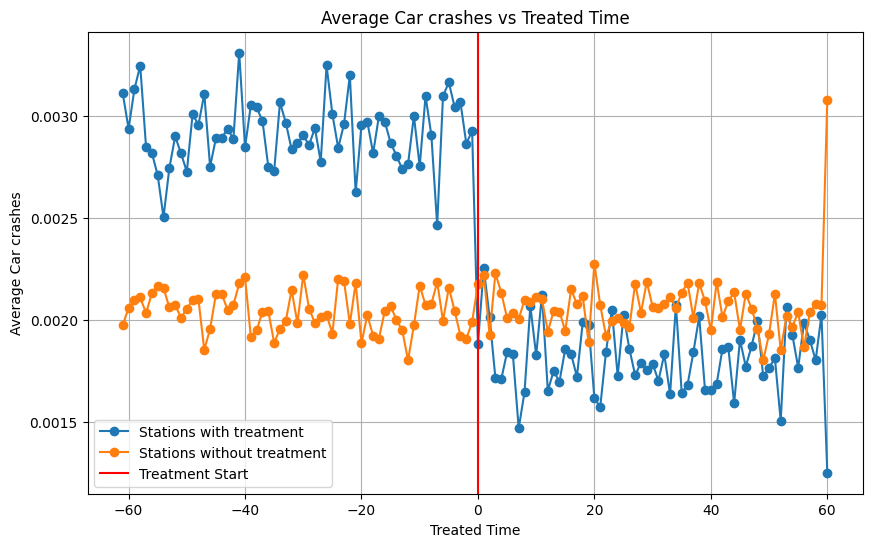

In [18]:
#Now we'll do the same analysis for the averages of car crashes and pedestrian deaths averages.

plt.figure(figsize=(10, 6))
plt.plot(df_polApp_avg['treated_time'],df_polApp_avg['carCrash'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['treated_time'],df_polNA_avg['carCrash'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average Car crashes')
plt.title('Average Car crashes vs Treated Time')
plt.grid(True)
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [19]:
df_polApp_avg["group"] = 1  # treated
df_polNA_avg["group"] = 0  # control

df_all = pd.concat([df_polApp_avg, df_polNA_avg], ignore_index=True)

df_all["post"] = df_all["treated_time"] >= 0

model = smf.ols("carCrash ~ group + post + group:post + C(dow)", data=df_all).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               carCrash   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     205.4
Date:                Wed, 07 May 2025   Prob (F-statistic):          8.66e-106
Time:                        14:54:50   Log-Likelihood:                 1801.6
No. Observations:                 244   AIC:                            -3583.
Df Residuals:                     234   BIC:                            -3548.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0020   3.12

The R^2 of 0.888 implies that the model is pretty accurate, and the group:post DiD coefficient is very close to 0, but, the p-value (0.00) is lower than 0.000, so the treatment had a big impact in the frequency of car crashes.

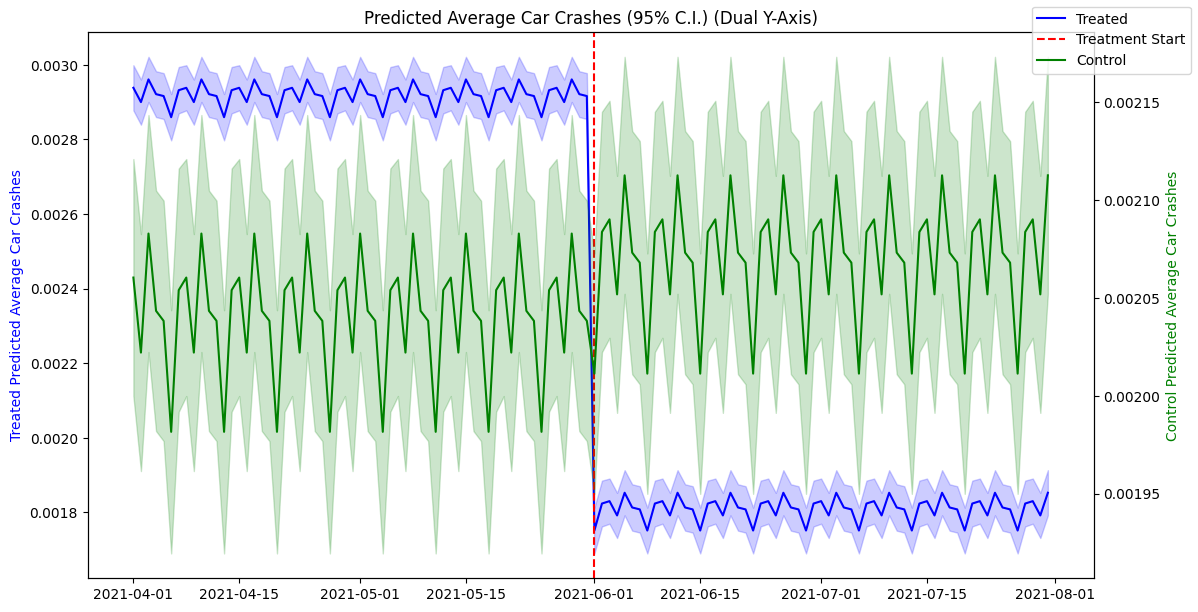

In [20]:
predictions=model.get_prediction(df_all)

df_all['predictedCrashes']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all['group_label']=df_all['group'].map({0:"Control",1:"Treated"})
df_all["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all = df_all.dropna(subset=['predictedCrashes', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all[df_all['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedCrashes'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Average Car Crashes', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all[df_all['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedCrashes'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Average Car Crashes', color='green')

# Treatment start line
treatment_start = df_all[df_all['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Average Car Crashes (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

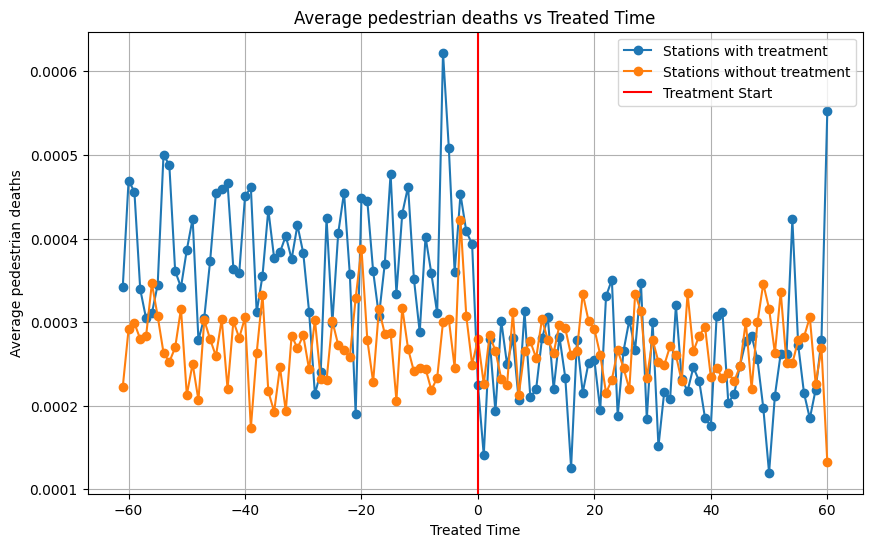

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(df_polApp_avg['treated_time'],df_polApp_avg['pedestrianDeath'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['treated_time'],df_polNA_avg['pedestrianDeath'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average pedestrian deaths')
plt.title('Average pedestrian deaths vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.grid(True)
plt.legend()

In [22]:
model = smf.ols("pedestrianDeath ~ group + post + group:post + C(dow)", data=df_all).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        pedestrianDeath   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     22.35
Date:                Wed, 07 May 2025   Prob (F-statistic):           3.32e-27
Time:                        14:54:51   Log-Likelihood:                 2032.5
No. Observations:                 244   AIC:                            -4045.
Df Residuals:                     234   BIC:                            -4010.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0003   1.21

The R^2 of 0.462 implies that the model is decently accurate, and although the group:post DiD coefficient is very close to 0, the p-value (0.00) is lower than 0.000, so the treatment had a clear impact in the frequency of pedestrian deaths.

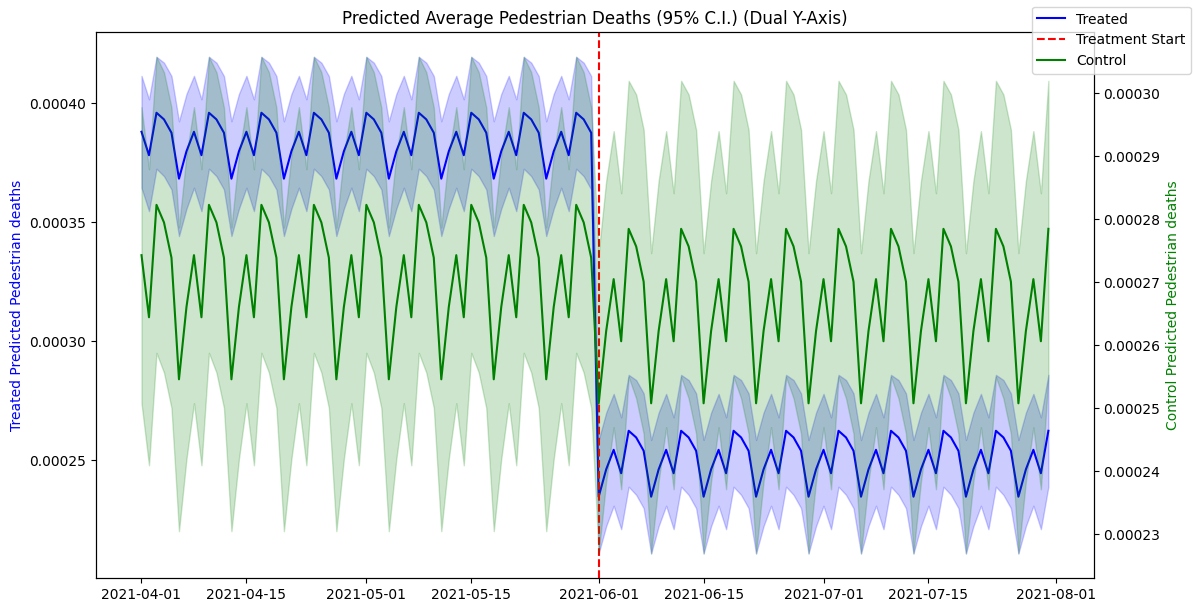

In [23]:
predictions=model.get_prediction(df_all)

df_all['predictedPedestrianDeath']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all['group_label']=df_all['group'].map({0:"Control",1:"Treated"})
df_all["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all = df_all.dropna(subset=['predictedPedestrianDeath', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all[df_all['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedPedestrianDeath'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Pedestrian deaths', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all[df_all['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedPedestrianDeath'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Pedestrian deaths', color='green')

# Treatment start line
treatment_start = df_all[df_all['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Average Pedestrian Deaths (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()